In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## 数据读取+特征转换
import polars as pl
import pandas as pd
import sys
sys.path.append("..")
from utils.models import *
from utils.alpha import *

def transform_data(df: pl.DataFrame):
    print(df['instrument'][0])
    df = build_alpha158(df)
    df = build_label(df)
    return df

pldf = pl.read_csv("../data/cleaned/csi300_stock_feats.csv")
stock_10 = pldf.select(["instrument"]).unique().head(10)
pldf = pldf.filter(pl.col('instrument').is_in(stock_10['instrument']))
pldf = pldf.group_by('instrument').map_groups(transform_data)
# pldf = transform_data(pldf.filter(pl.col('instrument') == 'SH600009'))
# print(pldf)

/mnt/disk1/JXH/01_apps/miniforge3/envs/finbot/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SH600008
SH601698
SH600019
SZ002385
SH601916
SZ002493
SZ000538
SH601066
SZ002010
SH600535


In [3]:
df = pldf.to_pandas()
label = 'LABEL0'
features = [col for col in df.columns if col.isupper() and col!=label]
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index(['instrument', 'datetime'], inplace=True)
df.dropna(inplace=True)
df[label] = df.groupby('instrument')[label].transform(lambda x: (x - x.mean()) / x.std())

In [15]:
years = df.index.get_level_values('datetime').year
df_1617 = df[years.isin([2016, 2017])].copy()   # train
df_18 = df[years == 2018].copy()    # val
df_19 = df[years == 2019].copy()    # test

In [18]:
model = BaseModel.use_subclass('lgb')()
model.train(df_1617, df_18, features, label)

[20]	train's l2: 0.5842	valid's l2: 1.39401
[40]	train's l2: 0.479266	valid's l2: 1.41232
[60]	train's l2: 0.390072	valid's l2: 1.42914
[80]	train's l2: 0.320715	valid's l2: 1.44315
[100]	train's l2: 0.265253	valid's l2: 1.45651
[120]	train's l2: 0.215686	valid's l2: 1.47047
[140]	train's l2: 0.181268	valid's l2: 1.48108
[160]	train's l2: 0.148608	valid's l2: 1.48881
[180]	train's l2: 0.124387	valid's l2: 1.49907
[200]	train's l2: 0.10279	valid's l2: 1.5052
[220]	train's l2: 0.0868542	valid's l2: 1.50939
[240]	train's l2: 0.0740989	valid's l2: 1.51306
[260]	train's l2: 0.0627534	valid's l2: 1.51683
[280]	train's l2: 0.0533729	valid's l2: 1.5199
[300]	train's l2: 0.0456621	valid's l2: 1.52248
[320]	train's l2: 0.0395057	valid's l2: 1.52534
[340]	train's l2: 0.0343015	valid's l2: 1.52712
[360]	train's l2: 0.0302251	valid's l2: 1.53087
[380]	train's l2: 0.0266876	valid's l2: 1.53188
[400]	train's l2: 0.0237104	valid's l2: 1.53449
[420]	train's l2: 0.021236	valid's l2: 1.53568
[440]	train'

In [14]:
import backtrader as bt
from utils.backtest import MyPandasData, MyStrategy

# 创建Cerebro并添加数据
cerebro = bt.Cerebro()
for instrument, group in model.pred(df_19, features).groupby('instrument'):
    group = group.reset_index(level=0, drop=True)
    cerebro.adddata(MyPandasData(dataname=group), name=instrument)
cerebro.addstrategy(MyStrategy)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="SharpeRatio")
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="AnnualReturn")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="DrawDown")

cerebro.broker.set_cash(1e6) # 设定初始资金
cerebro.broker.setcommission(commission=6e-4) # 设定手续费
result = cerebro.run()
# plt.figure()
# cerebro.plot(style='bar')
# plt.show()
print(result[0].analyzers.SharpeRatio.get_analysis())
print(result[0].analyzers.AnnualReturn.get_analysis())
print(result[0].analyzers.DrawDown.get_analysis()['max'])

OrderedDict([('sharperatio', None)])
OrderedDict([(2019, 0.04305277424191001)])
AutoOrderedDict([('len', 16), ('drawdown', 1.1051645297787052), ('moneydown', 11193.377749999985)])


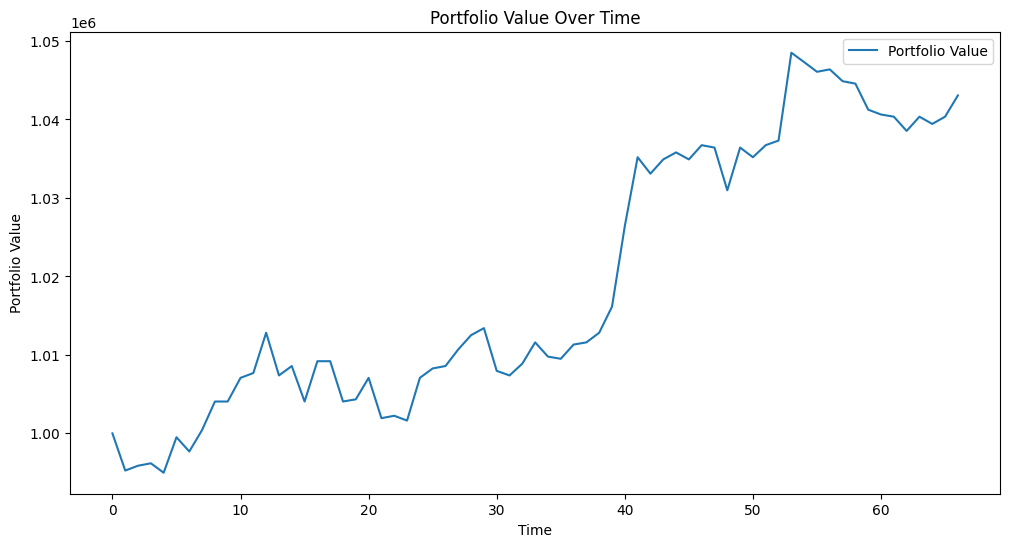

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
# 获取组合的净值曲线
portfolio_value = cerebro.broker.get_value()
portfolio_values = result[0].portfolio_values

# 绘制净值曲线
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()